### Importing key libraries

In [1]:
import os, json, yaml, warnings, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import optuna

warnings.filterwarnings('ignore')

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Uncommon packages
# !pip install -q split-folders optuna-integration

### TF configuration

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

### Non-optimized hyperparameters

In [4]:
IMG_SIZE = 224
NUM_EPOCHS = 100
# EarlyStopping
PATIENCE = 5 # no. of epochs with no improvement after which training will be stopped
# ReduceLROnPlateau
LR_PATIENCE = 5 # no. of epochs with no improvement after which learning rate will be reduced
LR_FACTOR = 0.1 # factor by which the learning rate will be reduced
MIN_LR = 1e-6 # lower bound on the learning rate
# Optuna
OPTUNA_TRIALS = 50

### Dataset splitting (one-time)

In [5]:
output_dir = r'splitted_data' # Intentionally declared in separate cell

In [6]:
# import splitfolders

# dataset_dir = r'dataset'

# # Make output dir if doesn't exist, else skip
# os.makedirs(output_dir, exist_ok=True)

# splitfolders.ratio(dataset_dir, output=output_dir, seed=1337, ratio=(0.75, 0.15, 0.1))
# print(f"Dataset successfully splitted into: {os.listdir(output_dir)}")

### Dataset config

In [7]:
def helper_ds(partition, shuffle_status=True):
    return tf.keras.utils.image_dataset_from_directory(
        directory=os.path.join(output_dir, partition),
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        label_mode='binary',
        shuffle=shuffle_status
    )

train_ds = helper_ds('train')
val_ds = helper_ds('val')
test_ds = helper_ds('test', False)


# Rescale layer
rescale_layer = tf.keras.layers.Rescaling(1./255)

# Data augmentation for 'train' set
data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.15),
        ])

AUTOTUNE = tf.data.AUTOTUNE

# Augmentation and rescaling for 'train' set
train_rsc = train_ds.map(lambda x, y: (rescale_layer(data_augmentation(x), training=True), y), num_parallel_calls=AUTOTUNE)
train_rsc = train_rsc.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Only rescaling for 'test' and 'val' set
val_rsc = val_ds.map(lambda x, y: (rescale_layer(x), y), num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)
test_rsc = test_ds.map(lambda x, y: (rescale_layer(x), y), num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)

Found 31344 files belonging to 2 classes.
Found 6268 files belonging to 2 classes.
Found 4181 files belonging to 2 classes.


In [8]:
class_names = train_ds.class_names
print(f"Class names: {class_names}")

# Saving the class names
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)

# Sanity check
print(f"Class names successfully saved.") if os.path.exists('class_names.json') else print(f"Failed to save the file.")

Class names: ['Drowsy', 'Non Drowsy']
Class names successfully saved.


### Data visualization

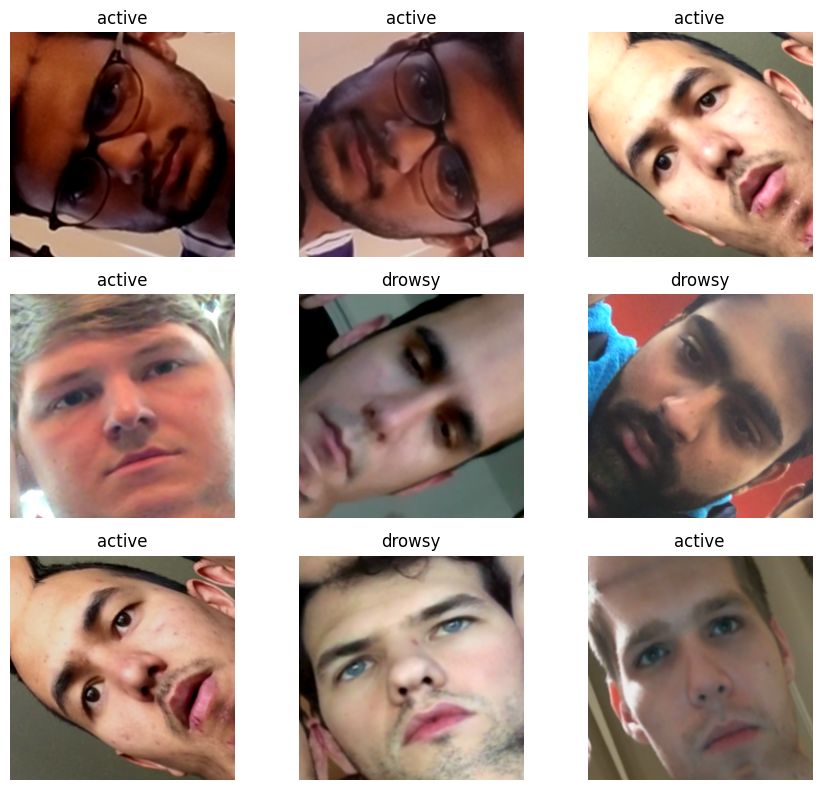

In [9]:
plt.figure(figsize=(10, 8))
for images, labels in train_rsc.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        state = "active" if int(labels[i]) else "drowsy"
        plt.title(state)
        plt.axis("off")
        plt.tight_layout()

### Stacking models

In [10]:
def stacked_model(input_shape=[IMG_SIZE, IMG_SIZE, 3], LEARNING_RATE=0.0001, DROPOUT_RATE=0.2):

    d_net = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    e_net = tf.keras.applications.EfficientNetV2B2(include_top=False, weights='imagenet', input_shape=input_shape)
    m_net = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze the models
    d_net.trainable=False; e_net.trainable=False; m_net.trainable=False

    # Input layer
    inputs = tf.keras.Input(shape=input_shape)

    # Averaging the outputs from each model
    d_net_gap = tf.keras.layers.GlobalAveragePooling2D()(d_net(inputs))
    e_net_gap = tf.keras.layers.GlobalAveragePooling2D()(e_net(inputs))
    m_net_gap = tf.keras.layers.GlobalAveragePooling2D()(m_net(inputs))

    # Combine outputs
    combined_outputs = tf.keras.layers.concatenate([d_net_gap, e_net_gap, m_net_gap])

    # Custom layers
    stacked_1 = tf.keras.layers.Dense(1024, activation='relu')(combined_outputs)
    stacked_1 = tf.keras.layers.BatchNormalization()(stacked_1)
    stacked_1 = tf.keras.layers.Dropout(DROPOUT_RATE)(stacked_1)

    stacked_2 = tf.keras.layers.Dense(512, activation='relu')(stacked_1)
    stacked_2 = tf.keras.layers.BatchNormalization()(stacked_2)
    stacked_2 = tf.keras.layers.Dropout(DROPOUT_RATE)(stacked_2)

    stacked_3 = tf.keras.layers.Dense(256, activation='relu')(stacked_2)
    stacked_3 = tf.keras.layers.BatchNormalization()(stacked_3)
    stacked_3 = tf.keras.layers.Dropout(DROPOUT_RATE)(stacked_3)

    out = tf.keras.layers.Dense(1, activation='sigmoid')(stacked_3)

    model = tf.keras.Model(inputs=inputs, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
    return model

### Defining callbacks

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=LR_FACTOR, patience=LR_PATIENCE, min_lr=MIN_LR)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoints/best_model.keras", monitor='val_loss', save_best_only=True, verbose=1)

# Custom training curve callback
from IPython.display import clear_output

train_losses=[]; val_losses=[]; precision_scores=[]; recall_scores=[]

class TrainingCurveCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_losses.append(logs['loss'])
        val_losses.append(logs['val_loss'])
        precision_scores.append(logs['precision'])
        recall_scores.append(logs['recall'])

        clear_output(wait=True) # clear output before plotting

        fig, ax1 = plt.subplots(figsize=(10, 5)) # create figure; will contain loss/accuracy curves
        fig.suptitle('Training Curves')

        # loss curve (ax1 - left y axis)
        ax1.plot(train_losses, label='Train Loss')
        ax1.plot(val_losses, label='Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_xlim(left=0)
        ax1.set_ylabel('Loss function')

        # determine left y axis range from min/max loss values
        y_ax1_min = min(min(train_losses), min(val_losses)) # find lowest loss value across both curves
        y_ax1_min = max(0, y_ax1_min - 0.1) # add some padding to the bottom of the plot. lower bound can't be less than 0
        y_ax1_max = max(max(train_losses), max(val_losses)) + 0.1 # find highest loss value across both curves, add some padding to the top of the plot
        ax1.set_ylim(y_ax1_min, y_ax1_max) # set y axis limits

        # Best epoch (smallest loss)
        best_epoch = int(np.argmin(val_losses))
        best_loss = val_losses[best_epoch]

        # add veritcal line for best epoch
        ax1.vlines(best_epoch, ymin=0, ymax=y_ax1_max, linestyles='dashed', colors='black',
                   label=f'best epoch={best_epoch}\nval loss={best_loss:.3f}')
        ax1.legend(loc='upper left')

        # create right y axis for precision/recall curves
        ax2 = ax1.twinx()

        # Plot precision/recall (right y-axis)
        ax2.plot(precision_scores, label=f'Precision\n{precision_scores[best_epoch]:.3f} @ {best_epoch}', color='red')
        ax2.plot(recall_scores, label=f'Recall\n{recall_scores[best_epoch]:.3f} @ {best_epoch}', color='green')
        ax2.set_ylabel('Precision / Recall')
        ax2.set_ylim(0, 1)
        ax2.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

### Model summary (optional)

In [12]:
# ensemble_model = stacked_model()
# ensemble_model.summary()

### Running Optuna

In [13]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'LEARNING_RATE': trial.suggest_loguniform('LEARNING_RATE', 1e-5, 1e-2),
        'DROPOUT_RATE': trial.suggest_float('DROPOUT_RATE', 0.1, 0.5, step=0.1),
    }
    ensemble_model = stacked_model(LEARNING_RATE=params['LEARNING_RATE'], DROPOUT_RATE=params['DROPOUT_RATE'])

    optuna_pruner = optuna.integration.TFKerasPruningCallback(trial, monitor='val_loss')

    history = ensemble_model.fit(train_rsc, validation_data=val_rsc, epochs=NUM_EPOCHS,
                             callbacks=[early_stopping, reduce_lr, optuna_pruner])

    return min(history.history['val_loss'])
    
study = optuna.create_study(direction='minimize') # minimize validation loss
study.optimize(objective, n_trials=OPTUNA_TRIALS, show_progress_bar=True)

[I 2025-07-09 09:56:23,905] A new study created in memory with name: no-name-2a7e68ad-3927-4fcf-ab69-1c0ab880dac5


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/100
980/980 [==============================] - 425s 413ms/step - loss: 0.3889 - accuracy: 0.8217 - auc: 0.9086 - precision: 0.7972 - recall: 0.8273 - val_loss: 0.1144 - val_accuracy: 0.9667 - val_auc: 0.9957 - val_precision: 0.9829 - val_recall: 0.9448 - lr: 3.7817e-05
Epoch 2/100
980/980 [==============================] - 400s 408ms/step - loss: 0.1285 - accuracy: 0.9506 - auc: 0.9898 - precision: 0.9444 - recall: 0.9499 - val_loss: 0.0590 - val_accuracy: 0.9815 - val_auc: 0.9988 - val_precision: 0.9698 - val_recall: 0.9911 - lr: 3.7817e-05
Epoch 3/100
980/980 [==============================] - 400s 408ms/step - loss: 0.0705 - accuracy: 0.9749 - auc: 0.9967 - precision: 0.9716 - recall: 0.9746 - val_loss: 0.0334 - val_accuracy: 0.9890 - val_auc: 0.9996 - val_precision: 0.9821 - val_recall: 0.9945 - lr: 3.7817e-05
Epoch 4/100
980/980 [==============================] - 400s 409ms/step - loss: 0.0485 - accuracy: 0.9831 - auc: 0.9984 - precision: 0.9822 - recall: 0.9814 - val_loss

In [14]:
# Get the best trial's value and hyperparameters
best_val = study.best_value
best_params = study.best_params
print(f'Best value: {best_val}\nBest hyperparameters found: {best_params}')

Best value: 0.0015050352085381746
Best hyperparameters found: {'LEARNING_RATE': 0.00019019401323957022, 'DROPOUT_RATE': 0.1}


In [15]:
# Save the best hyperparameters to a file
with open('best_hyperparameters.yaml', 'w') as f:
    yaml.dump(best_params, f)

### Training the final model

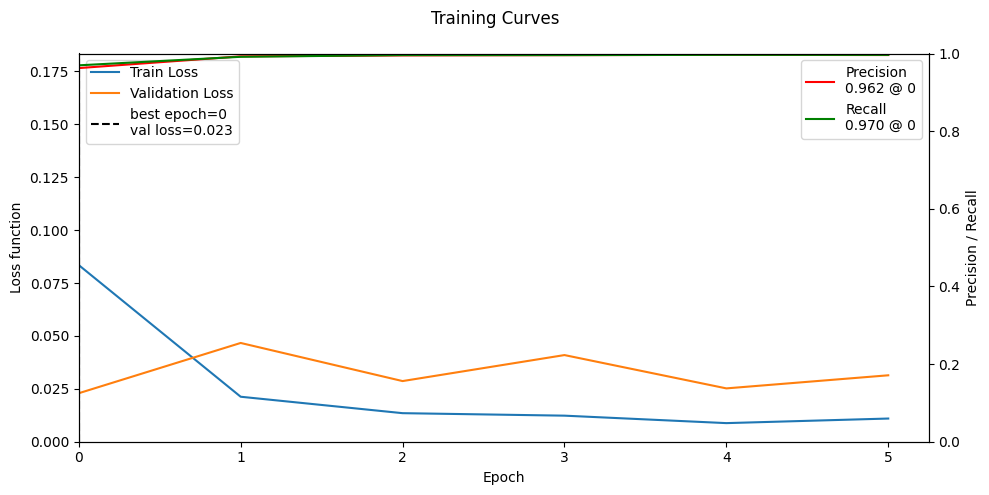

980/980 [==============================] - 404s 412ms/step - loss: 0.0110 - accuracy: 0.9965 - auc_50: 0.9998 - precision: 0.9960 - recall: 0.9964 - val_loss: 0.0314 - val_accuracy: 0.9909 - val_auc_50: 0.9990 - val_precision: 0.9844 - val_recall: 0.9962 - lr: 1.9019e-04


In [16]:
# Load the ensemble model again
ensemble_model = stacked_model(LEARNING_RATE=best_params['LEARNING_RATE'], DROPOUT_RATE=best_params['DROPOUT_RATE'])

history = ensemble_model.fit(train_rsc, validation_data=val_rsc, epochs=NUM_EPOCHS,
                             callbacks=[early_stopping, reduce_lr, TrainingCurveCallback()])

### Saving the model

In [17]:
model_filename = 'optuna_final.keras' # Intentionally declared in separate cell

In [18]:
ensemble_model.save(model_filename)

# Sanity check
print(f"Model successfully saved as {model_filename}") if os.path.exists(model_filename) else print(f"Failed to save the model.")

Model successfully saved as optuna_final.keras


### Loading the model

In [19]:
optimized_ensemble = tf.keras.models.load_model(model_filename) # Intentionally declared in separate cell

### Model evaluation (w/ val dataset)

In [20]:
final_val_loss, final_val_accuracy, *rest = optimized_ensemble.evaluate(val_rsc)
print(f"Ensemble Model - Validation Loss: {final_val_loss:.4f}, Validation Accuracy: {final_val_accuracy:.4f}")

196/196 [==============================] - 73s 338ms/step - loss: 0.0229 - accuracy: 0.9943 - auc_50: 0.9997 - precision: 0.9986 - recall: 0.9890
Ensemble Model - Validation Loss: 0.0229, Validation Accuracy: 0.9943


### Model testing (w/ test dataset)

1/1 [==============================] - 8s 8s/step


<Figure size 800x800 with 0 Axes>

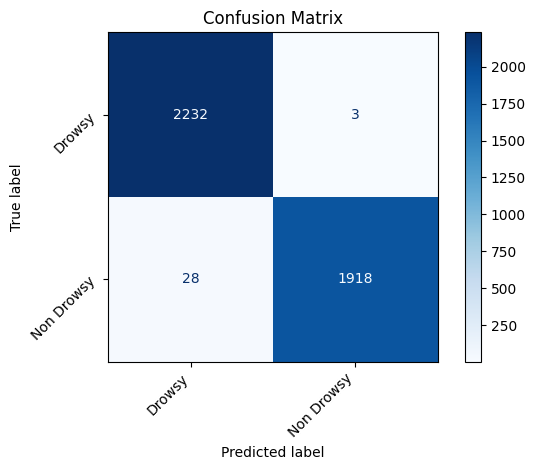

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = []; y_true = []

# Collecting predictions and true labels
for images, labels in test_rsc:
    preds = optimized_ensemble.predict(images)
    y_pred.extend((preds > 0.5).astype(int))
    y_true.extend(labels.numpy())

# Computing confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(8,8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### Model testing 2 (w/ external data)

In [23]:
# # Define the external dataset path
# external_data_dir = 'path_here'
# predictions = []

# plt.figure(figsize=(15, 15))

# counter = 1
# print("Predictions for Test Dataset:")
# for img_file in os.listdir(external_data_dir):
#     if img_file.endswith(('.png', '.jpg', '.jpeg')):
#         img_path = os.path.join(external_data_dir, img_file)

#         # Load and preprocess the image
#         img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
#         img_array = tf.keras.preprocessing.image.img_to_array(img)
#         img_array = np.expand_dims(img_array, axis=0)

#         preds = optimized_ensemble.predict(img_array)
#         predicted_class_index = np.argmax(preds, axis=1)[0]

#         # Store the prediction along with the image filename
#         predictions.append((img_file, class_names[predicted_class_index]))

#         # Display the image and prediction
#         plt.subplot(4, 4, counter)
#         plt.imshow(img)
#         plt.title(f"Predicted: {class_names[predicted_class_index]}")
#         plt.axis('off')
        
#         counter += 1

# plt.tight_layout()
# plt.show()